# Python libraries for raster data

This notebook based on content from previous geohackweek raster tutorials https://github.com/geohackweek/raster

<blockquote class="objectives">
    
## Overview

<div style="float: left;">

**teaching:** 30 minutes
    
**exercises:** 0
    </div> 
    
|questions| objectives | 
|:----------| :---  |
| What python libraries can I use to work with raster data?  | Understand the relationship between numpy, rasterio, and GDAL |  
 
</blockquote>


1. [**Numpy**](#Numpy)
1. [**Rasterio**](#Rasterio)
1. [**Image and World coordinates**](#Image-and-World-coordinates)
1. [**Other libraries**](#Image-and-World-coordinates)

## Numpy

Because rasters are images, they are best thought of as 2-dimensional arrays.  If we have multiple bands, we could think of an image as a 3-dimensional array. Either way, we are working with arrays (matrices) of pixel values, which in the
Python programming language are usually represented by [NumPy](http://numpy.org) arrays.

For this tutorial, we'll perform basic operations with NumPy arrays extracted from geospatial rasters.  For more information about multidimensional array analysis, take a look at the geohackweek tutorial on [N-Dimensional Arrays](https://geohackweek.github.io/nDarrays).

In [8]:
# Create raster data
import numpy as np

nx = 60
ny = 45
x = np.linspace(-4.0, 4.0, nx)
y = np.linspace(-3.0, 3.0, ny)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-2 * np.log(2) * ((X - 0.5) ** 2 + (Y - 0.5) ** 2) / 1 ** 2)
Z2 = np.exp(-3 * np.log(2) * ((X + 0.5) ** 2 + (Y + 0.5) ** 2) / 2.5 ** 2)
Z = 10.0 * (Z2 - Z1)

In [9]:
print(type(Z))
print(Z)

<class 'numpy.ndarray'>
[[0.02122529 0.02892972 0.03895127 ... 0.00325789 0.00221092 0.00148217]
 [0.02646584 0.0360725  0.04856839 ... 0.00406227 0.0027568  0.00184812]
 [0.03259447 0.04442573 0.05981526 ... 0.00500296 0.00339519 0.00227609]
 ...
 [0.00530875 0.00723575 0.00974228 ... 0.00081484 0.00055298 0.00037071]
 [0.00393665 0.00536559 0.00722429 ... 0.00060424 0.00041006 0.0002749 ]
 [0.00288328 0.00392987 0.00529121 ... 0.00044256 0.00030034 0.00020134]]


In [28]:
# Numpy arrays permit all kinds of operations on our raster data, some of the most common are:

# indexing
print('value at Z[25,20]: ', Z[25,20])
    
# slicing
print('first row, last 3 values: ', Z[0,-3:])

# math
print('mean of all values: ', np.mean(Z))

value at Z[25,20]:  6.060251397244279
first row, last 3 values:  [0.00325789 0.00221092 0.00148217]
mean of all values:  1.396442793554628


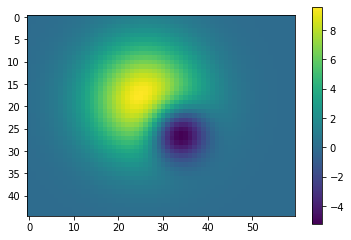

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize with matplotlib
plt.imshow(Z, origin='upper', interpolation='none')
plt.colorbar();

## Rasterio

An excellent python library supported by Mapbox is [rasterio](https://rasterio.readthedocs.io/en/latest/). Rasterio provides a "Pythonic" interface to GDAL and supports most of the features and formats that GDAL supports. Both GDAL and rasterio are constantly being updated and improved: As of writing this tutorial (August 2019), GDAL is at version 3.0.0 and rasterio is at version 1.0.25

**Rasterio uses numpy arrays to represent raster data. It also uses the [Proj4](https://github.com/OSGeo/PROJ) library and GDAL to manage geospatial operations.**

In the example below use rasterio to assign a CRS and geotransform to the data we just created. The coordinate reference system will be '+proj=latlong', which describes an equirectangular coordinate reference system with units of decimal degrees. The affine transformation matrix can be computed from the matrix product of a translation and a scaling:

In [13]:
# Create Affine geotransformation
from rasterio.transform import Affine

res = (x[-1] - x[0]) / 240.0
ulx = x[0] - res / 2
uly = y[-1] - res / 2
transform = Affine.translation(ulx, uly) * Affine.scale(res, -res)
transform

Affine(0.03333333333333333, 0.0, -4.016666666666667,
       0.0, -0.03333333333333333, 2.9833333333333334)

In [14]:
# Save as a Geotiff
import rasterio

with rasterio.open('example.tif', 'w',
                    driver='GTiff',
                    height=Z.shape[0],
                    width=Z.shape[1],
                    count=1,
                    dtype=Z.dtype,
                    crs='+proj=latlong', # this is a "proj4" string defining the projection
                    transform=transform,
                    ) as dst:
    dst.write(Z, 1)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 60, 'height': 45, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.03333333333333333, 0.0, -4.016666666666667,
       0.0, -0.03333333333333333, 2.9833333333333334), 'tiled': False, 'interleave': 'band'}


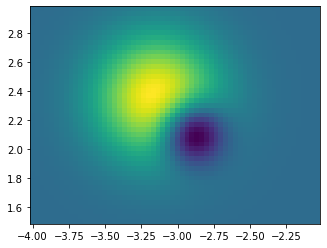

In [18]:
# Load the file into memory and plot
import rasterio.plot
with rasterio.open('example.tif') as src:
    print(src.profile)
    rasterio.plot.show(src)

## Image and World coordinates

We now have the same array but with georeferenced coordinates. We often know the georeferenced coordinates of a position of interest, but not the row,col of that position in a raster rasterio helps us manage our two sets of 'image' and 'world' coordinates:

In [40]:
# Note that with rasterio if we read the data into memory, we get our numpy array back
with rasterio.open('example.tif') as src:
    data = src.read()

In [63]:
# But rasterio appends an additional dimension corresponding to the raster band
print(type(data))
print(data)
print(data.shape)

<class 'numpy.ndarray'>
[[[0.02122529 0.02892972 0.03895127 ... 0.00325789 0.00221092 0.00148217]
  [0.02646584 0.0360725  0.04856839 ... 0.00406227 0.0027568  0.00184812]
  [0.03259447 0.04442573 0.05981526 ... 0.00500296 0.00339519 0.00227609]
  ...
  [0.00530875 0.00723575 0.00974228 ... 0.00081484 0.00055298 0.00037071]
  [0.00393665 0.00536559 0.00722429 ... 0.00060424 0.00041006 0.0002749 ]
  [0.00288328 0.00392987 0.00529121 ... 0.00044256 0.00030034 0.00020134]]]
(1, 45, 60)


In [65]:
lon, lat = -3.33, 2.13
with rasterio.open('example.tif') as src:
    row, col = src.index(lon, lat) # spatial --> image coordinates
    val = src.read(1)[row,col] # band 1, value at row,col

print('(Lon,Lat), (Row,Col), Value: ', (lon,lat), (row,col), val)

(Lon,Lat), (Row,Col), Value:  (-3.33, 2.13) (25, 20) 6.060251397244279


## Other libraries

This just scratches the surface of numpy and rasterio, but demonstrates the relationship between these foundational libraries. Many other libraries exist in the fields of geoprocessing (which would include hydrological routing and other routines needed for Earth Systems Sciences) and digital signal processing (including image classification, pattern recognition, and feature extraction)! 

<blockquote class="keypoints">

## key points 

  - Rasterio is built around the GDAL library (recall section 3), to facilitate raster operations in Python
  - Pixel values of rasters can be extracted to a numpy array
  - Computation is done in local memory on numpy arrays, then saved to the raster format of choice
    
</blockquote class="keypoints">

In [4]:
# Run to enable some familiar software carpentry lesson styling
from IPython.core.display import HTML
with open( './carpentries-lesson.css', 'r' ) as f: style = f.read()
HTML( style )